In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cmcrameri import cm
import numpy as np

In [2]:
## Import full enrichment results
data_dir = r"C:\Users\neil_\DellXPS_June2024\OneDrive\Desktop\New UHN\Precision Medicine\carotid_plaque\workflow\pathway_enrichment\\"
kegg_mirna = pd.read_csv(data_dir+"dem_pathways_kegg.csv")
go_mirna = pd.read_csv(data_dir+"dem_pathways_go.csv")
go_mirna.drop(columns=["pthwy_id"],inplace=True)

In [3]:
## Import filtered lists (filtered by SR)
data_dir = r"C:\Users\neil_\DellXPS_June2024\OneDrive\Desktop\New UHN\Precision Medicine\carotid_plaque\data\filtered_lists\\"
kegg_top = pd.read_csv(data_dir+"dem_kegg_top.txt", sep="\t", header=None) # NP removed redundant pathways "Longevity regulating pathway - multiple species", "Apoptosis - multiple species"
kegg_ec =  pd.read_csv(data_dir+"dem_kegg_ec.txt", sep="\t", header=None)

go_top = pd.read_csv(data_dir+"dem_go_top.txt", sep="\t", header=None)
go_ec =  pd.read_csv(data_dir+"dem_go_ec.txt", sep="\t", header=None)

In [4]:
class Enrichment:
    def __init__(self, db, all_df, top_df, ec_df):
        self.database = db
        self.enrichment_df = all_df
        self.top_pathways = list(set(top_df[0]))
        self.endo_pathways = list(set(top_df[0]))

In [5]:
GO_miRNA = Enrichment("GO BP", go_mirna, go_top, go_ec)
KEGG_miRNA = Enrichment("KEGG", kegg_mirna, kegg_top, kegg_ec)

In [6]:
def get_top_df(full_df, top_pthwys):
    filtered_df = full_df[full_df["pathway"].isin(top_pthwys)]
    return filtered_df



In [7]:
def get_pivot_df(filtered_df):
    pivot_df = filtered_df.pivot_table(index='pathway', columns='cohort', values='fold_enrichment')
    # Ensure 'symptomatic' and 'asymptomatic' columns exist with default values set to 1.0 if they don't
    if 'symptomatic' not in pivot_df.columns:
        pivot_df['symptomatic'] = np.nan
    if 'asymptomatic' not in pivot_df.columns:
        pivot_df['asymptomatic'] = np.nan
    
    # Reorder columns to ensure 'symptomatic' and 'asymptomatic' are in the right place if needed
    pivot_df = pivot_df[['asymptomatic', 'symptomatic']]

    pivot_df.fillna(1.0, inplace=True)
    return pivot_df

In [8]:
def filter_pivot_by_variation(pivot_df, n=30):
    variation = pivot_df.std(axis=1)
    top_n_labels = variation.nlargest(n).index
    filtered_pivot = pivot_df.loc[top_n_labels]
    return filtered_pivot

In [9]:
for Enr in [GO_miRNA, KEGG_miRNA]:
    full_df = Enr.enrichment_df
    top_pthwys = Enr.top_pathways
    # Only include pathways specified by SR
    Enr.filtered_df = get_top_df(full_df, top_pthwys)
    pivot_df = get_pivot_df(Enr.filtered_df)
    Enr.pivot_df = filter_pivot_by_variation(pivot_df)

## KEGG

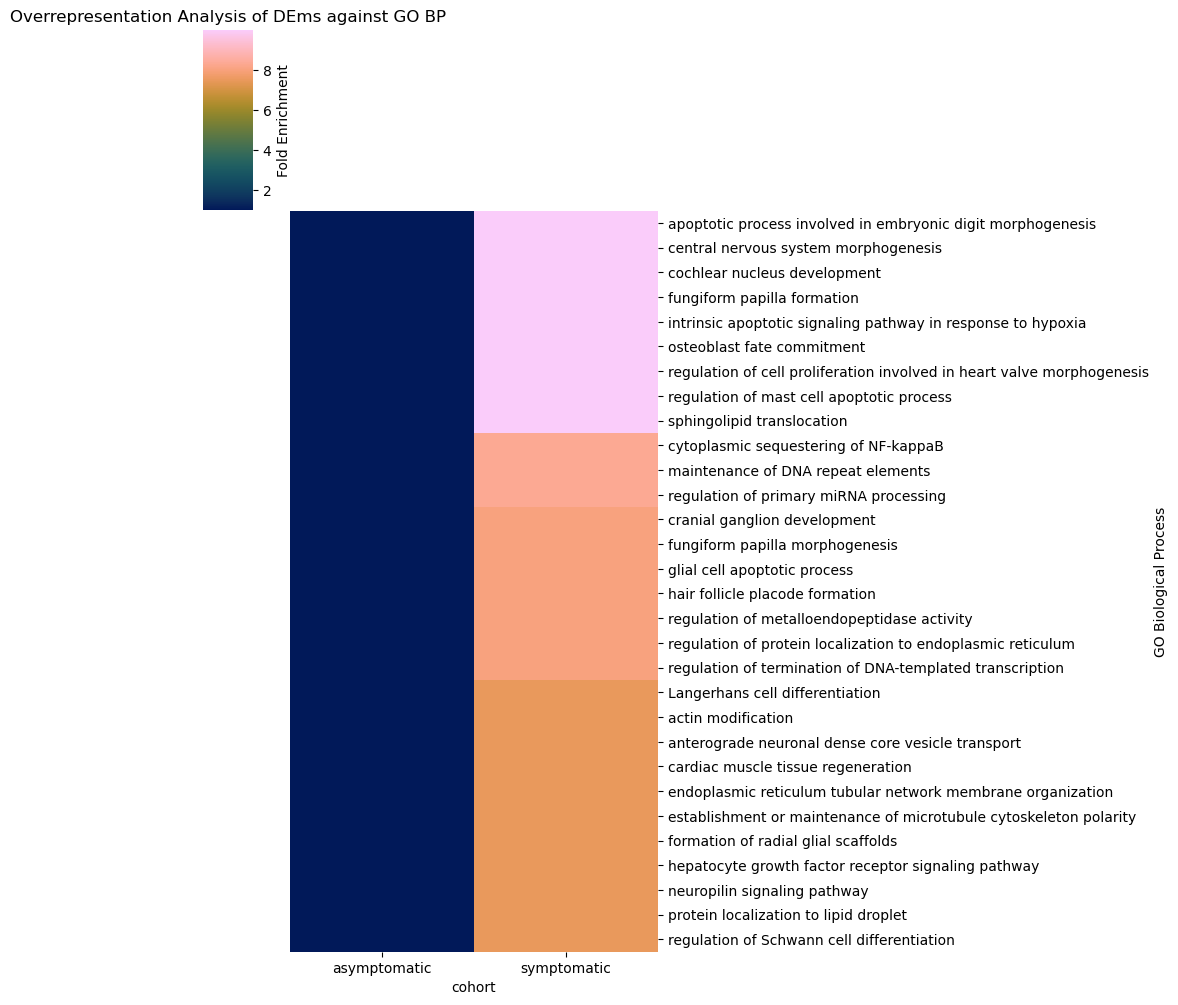

In [10]:
Enr = GO_miRNA
db = Enr.database
pivot_df = Enr.pivot_df.rename_axis("GO Biological Process")

# Plot 30 pathways heatmap
f = sns.clustermap(pivot_df,cmap=cm.batlow, figsize=(10, 10), annot=False, row_cluster=False, col_cluster=False)
#f = sns.clustermap(pivot_df, cmap=cm.batlow, figsize=(12, 12), annot=False)

plt.title(f'Overrepresentation Analysis of DEms against {db}')
plt.ylabel('Fold Enrichment')

f.savefig(f"dem_go_heatmap.pdf")
plt.show()

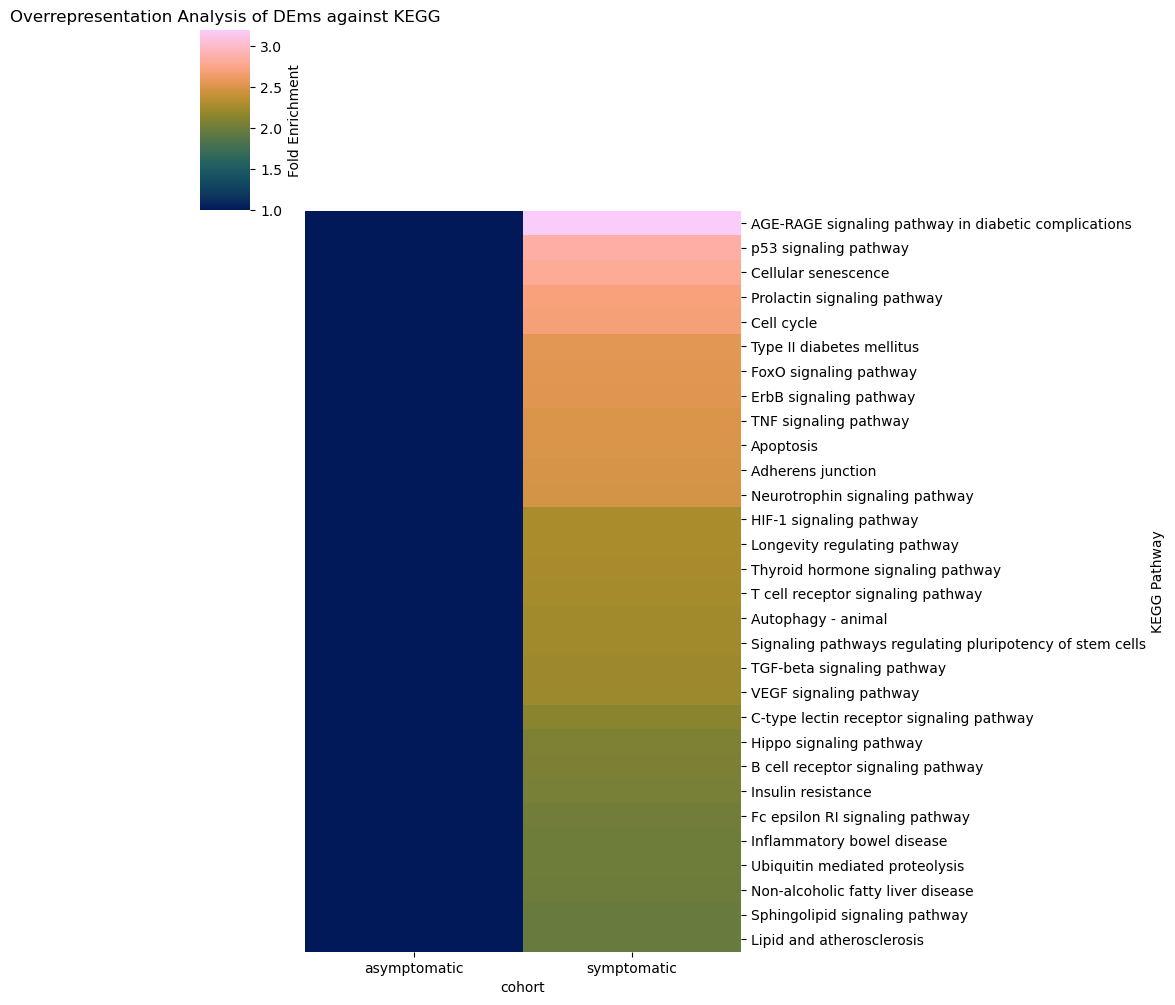

In [11]:
Enr = KEGG_miRNA
db = Enr.database
pivot_df = Enr.pivot_df.rename_axis("KEGG Pathway")

# Plot 30 pathways heatmap
f = sns.clustermap(pivot_df,cmap=cm.batlow, figsize=(10, 10), annot=False, row_cluster=False, col_cluster=False)
#f = sns.clustermap(pivot_df, cmap=cm.batlow, figsize=(12, 12), annot=False)

plt.title(f'Overrepresentation Analysis of DEms against {db}')
plt.ylabel('Fold Enrichment')

f.savefig(f"dem_kegg_heatmap.pdf")
plt.show()